In [90]:
import numpy as np
import pandas as pd
import seaborn as sns

from catboost import CatBoostClassifier
from matplotlib import pyplot as plt
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.tree import DecisionTreeClassifier, plot_tree
from pprint import pprint
from warnings import filterwarnings

filterwarnings("ignore", category=FutureWarning)

In [91]:
!pip install adbench openfe pyod > installer.log

# Load data

In [92]:
INPUT_DIR = "/kaggle/input/advanced-dls-spring-2021/"
data = pd.read_csv(INPUT_DIR + "train.csv")
X_test = pd.read_csv(INPUT_DIR + "test.csv")

num_cols = [
    "ClientPeriod",
    "MonthlySpending",
    "TotalSpent",
]

cat_cols = [
    "Sex",
    "IsSeniorCitizen",
    "HasPartner",
    "HasChild",
    "HasPhoneService",
    "HasMultiplePhoneNumbers",
    "HasInternetService",
    "HasOnlineSecurityService",
    "HasOnlineBackup",
    "HasDeviceProtection",
    "HasTechSupportAccess",
    "HasOnlineTV",
    "HasMovieSubscription",
    "HasContractPhone",
    "IsBillingPaperless",
    "PaymentMethod",
]

target = 'Churn'

# Clean data

In [93]:
data.replace(" ", np.nan, inplace=True)
X_test.replace(" ", np.nan, inplace=True)
data["TotalSpent"] = data.TotalSpent.fillna(0).astype(float)
X_test["TotalSpent"] = X_test.TotalSpent.fillna(0).astype(float)

# EDA

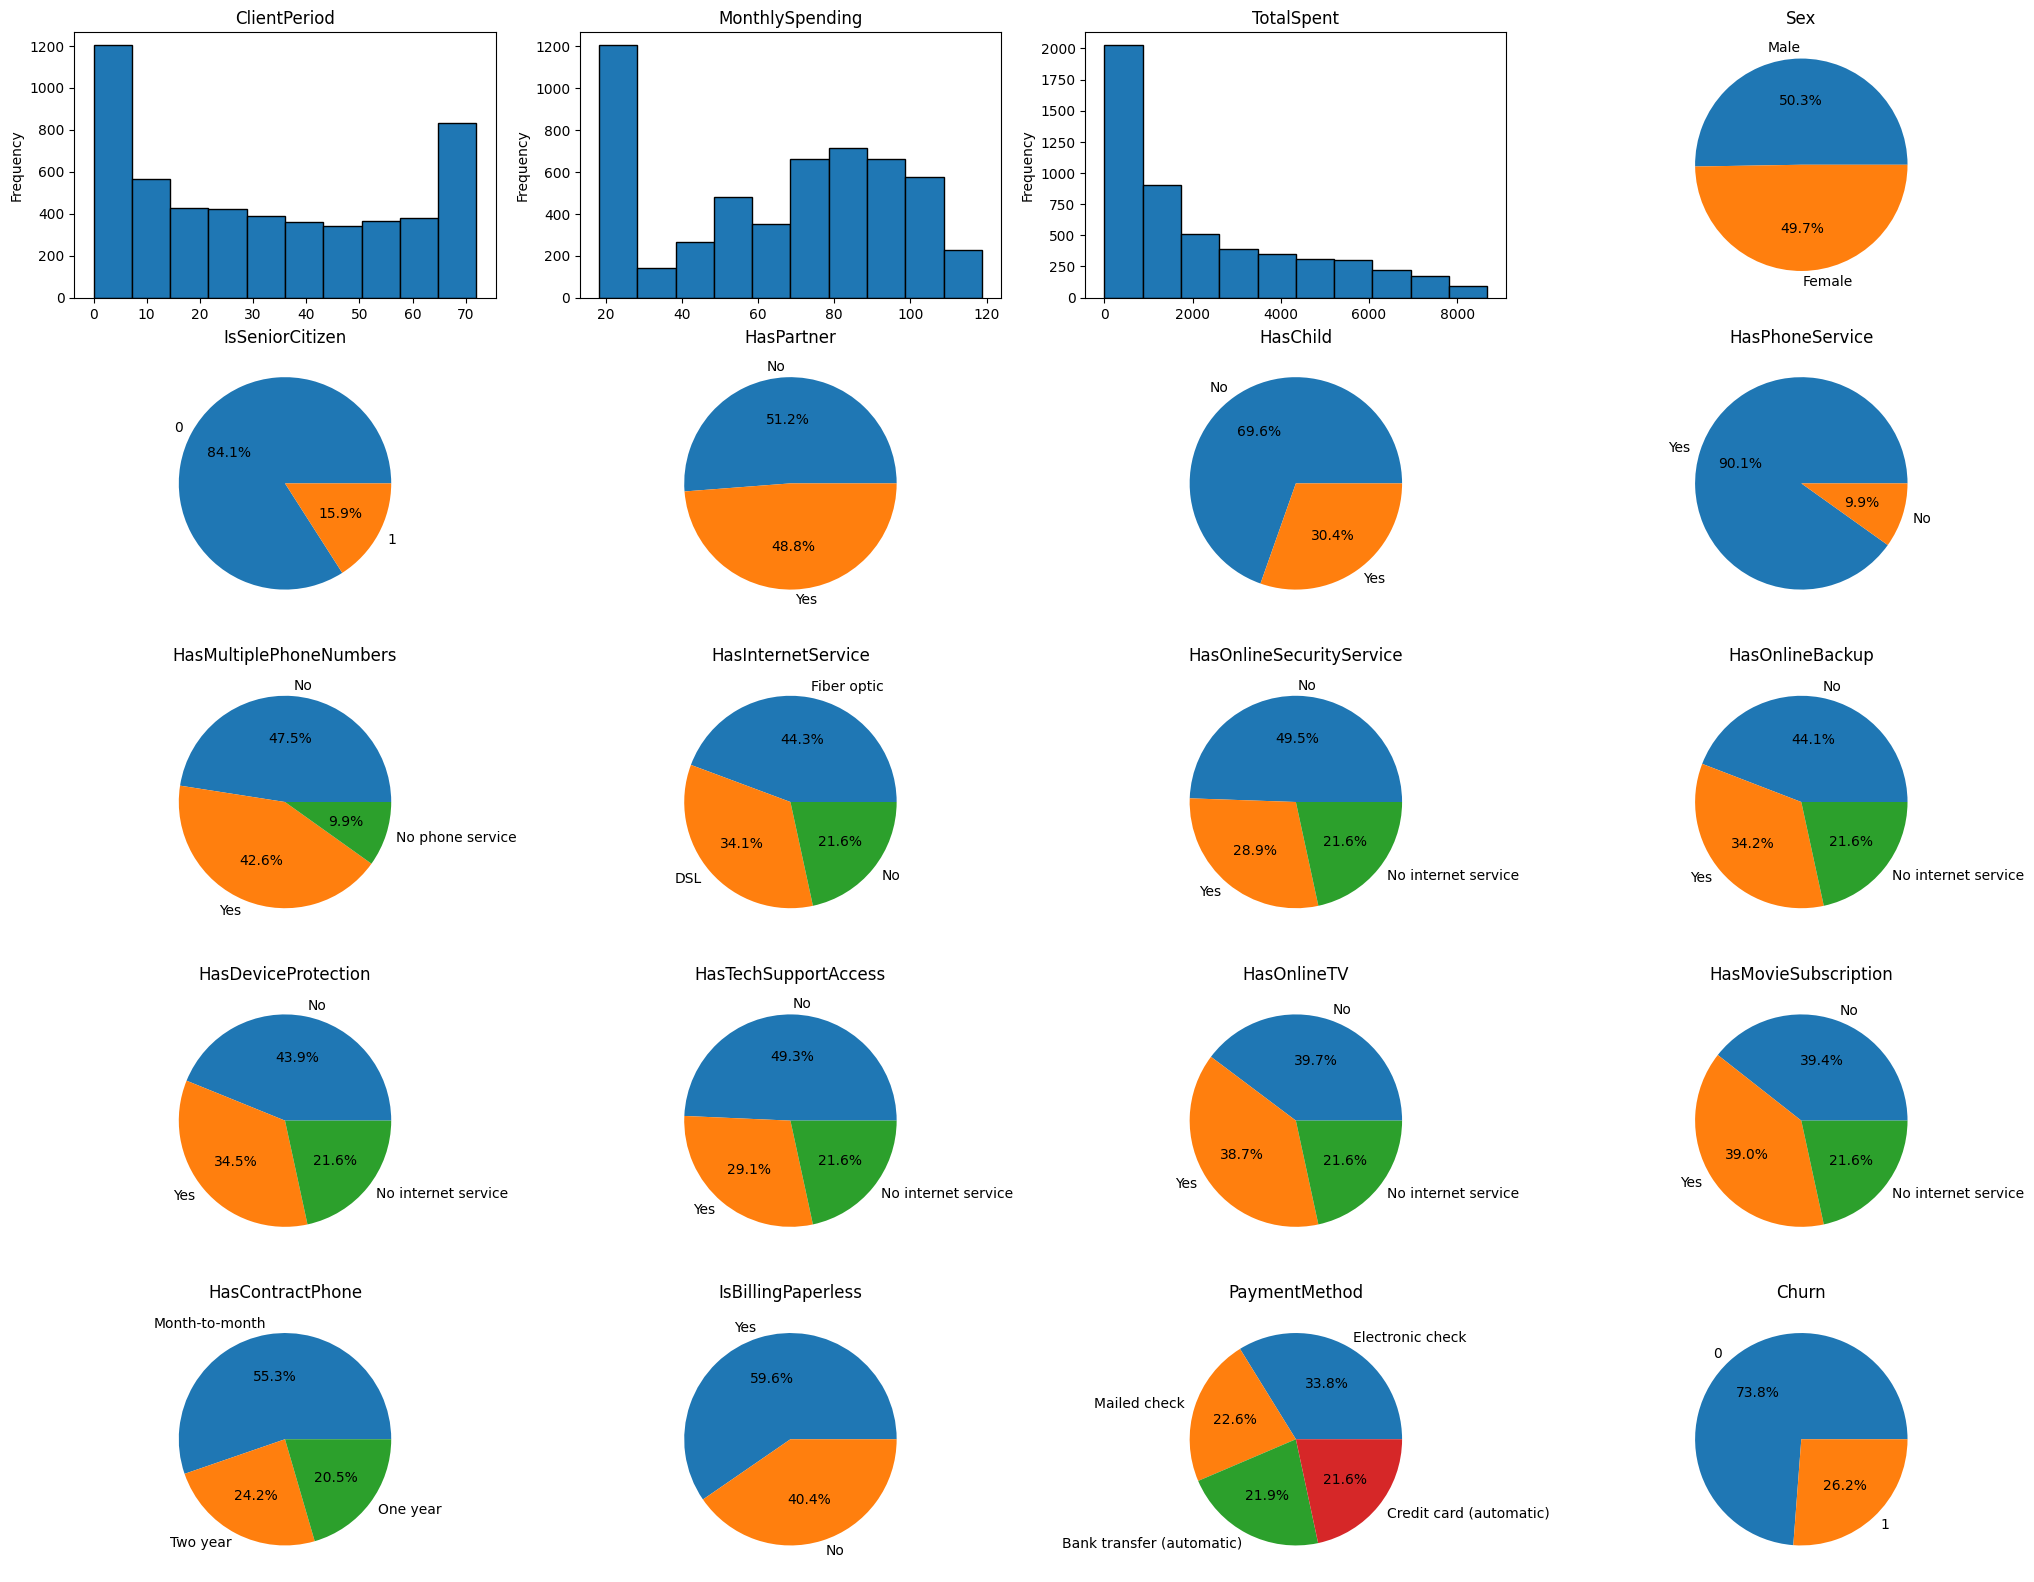

In [94]:
fig, axes = plt.subplots(5, 4, figsize=(25, 20))
for ax, col in zip(axes.flatten(), data.columns):
    ax.set_title(col)
    if col in cat_cols or col == target:
        ax.pie(data[col].value_counts(), autopct="%1.1f%%", labels=data[col].value_counts().index)
    else:
        data[col].plot(kind="hist", ec="black", ax=ax)

In [95]:
tmp = data.groupby("PaymentMethod", as_index=False).agg({"Churn": ["sum", "count"]})
tmp["Churn (%)"] = 100 * tmp["Churn", "sum"] / tmp["Churn", "count"]
tmp.sort_values("Churn (%)").reset_index(drop=True)

PaymentMethod Churn        Churn (%)
                               sum count           
0    Credit card (automatic)   165  1143  14.435696
1  Bank transfer (automatic)   195  1159  16.824849
2               Mailed check   230  1194  19.262982
3           Electronic check   794  1786  44.456887

In [96]:
tmp = data.groupby("HasContractPhone", as_index=False).agg({"Churn": ["sum", "count"]})
tmp["Churn (%)"] = 100 * tmp["Churn", "sum"] / tmp["Churn", "count"]
tmp.sort_values("Churn (%)").reset_index(drop=True)

HasContractPhone Churn        Churn (%)
                     sum count           
0         Two year    33  1280   2.578125
1         One year   120  1082  11.090573
2   Month-to-month  1231  2920  42.157534

In [97]:
tmp = data.groupby("HasInternetService", as_index=False).agg({"Churn": ["sum", "count"]})
tmp["Churn (%)"] = 100 * tmp["Churn", "sum"] / tmp["Churn", "count"]
tmp.sort_values("Churn (%)").reset_index(drop=True)

HasInternetService Churn        Churn (%)
                       sum count           
0                 No    82  1141   7.186678
1                DSL   342  1800  19.000000
2        Fiber optic   960  2341  41.008116

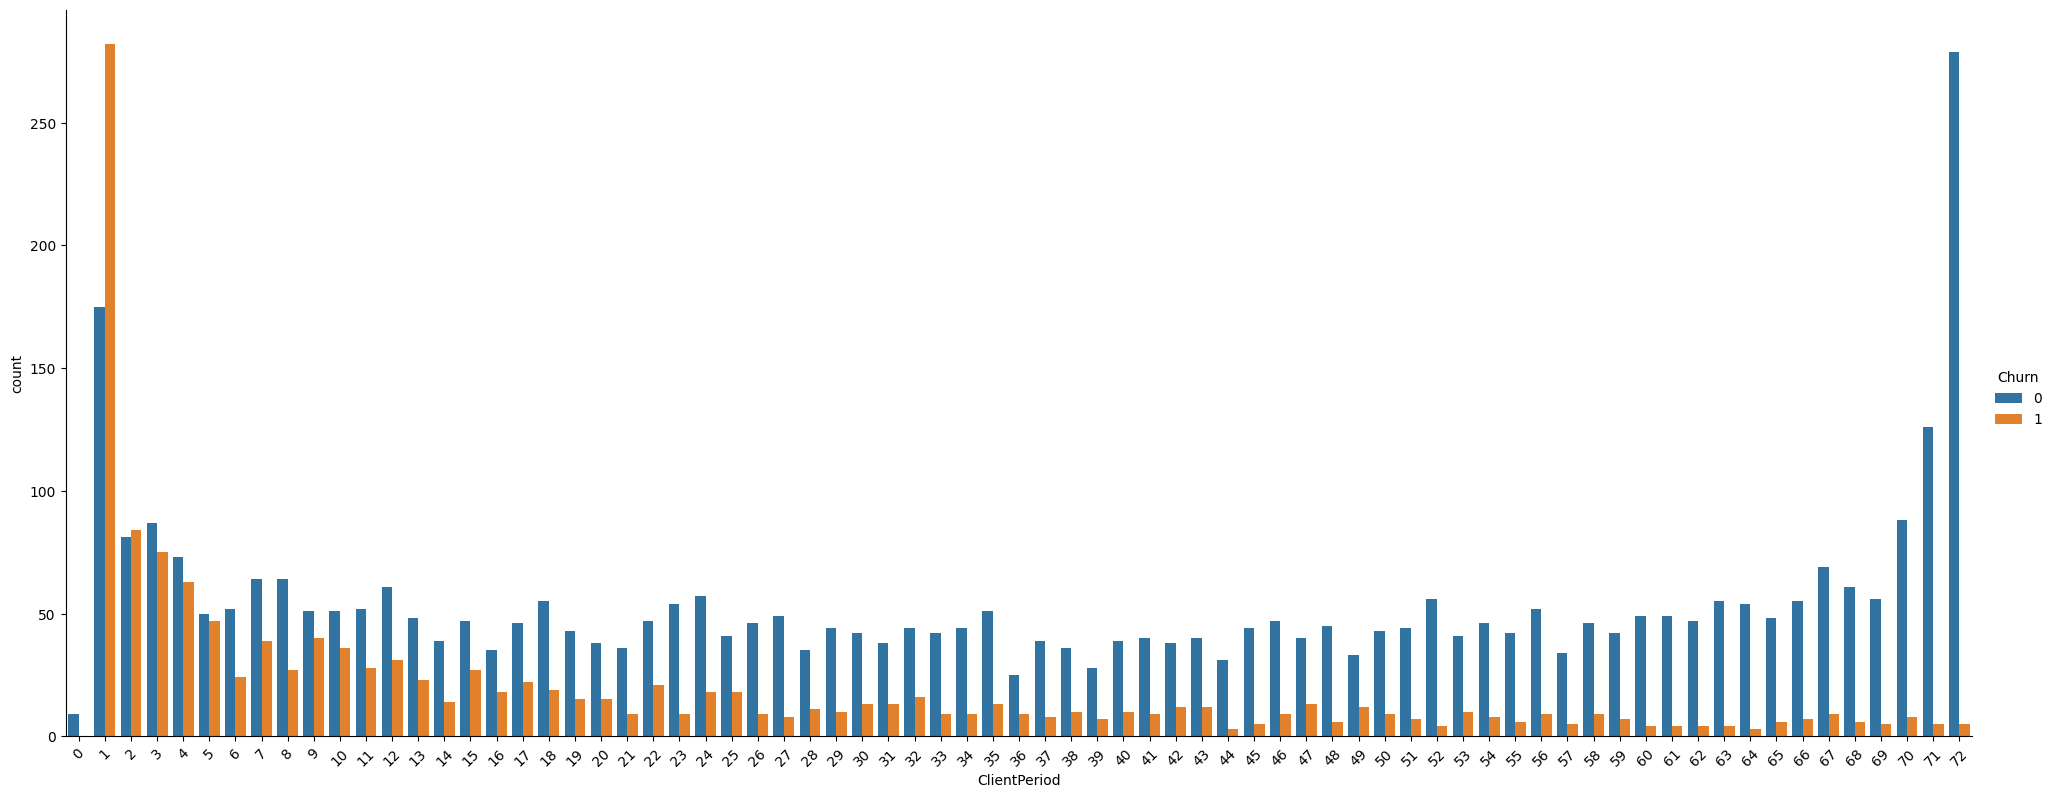

In [98]:
sns.catplot(data=data, x="ClientPeriod", hue="Churn", kind="count", height=8, aspect=20/8)
plt.xticks(rotation=45);

In [99]:
patterns = {
    "No": 0,
    "No internet service": 0,
    "No phone service": 0,
    "Yes": 1,
    "Male": 0,
    "Female": 1,
    "DSL": 1,
    "Fiber optic": 2,
    "Month-to-month": 0,
    "One year": 1,
    "Two year": 2,
    "Credit card (automatic)": 0,
    "Bank transfer (automatic)": 1,
    "Mailed check": 2,
    "Electronic check": 3,
}
X_train = data.replace(patterns).drop(target, axis=1)
y_train = data[target]
X_test = X_test.replace(patterns)

# OneHot Encode

In [100]:
X_train = pd.get_dummies(X_train, columns=['PaymentMethod'], prefix=['PaymentMethod'], dtype="int")
X_train = pd.get_dummies(X_train, columns=['HasInternetService'], prefix=['HasInternetService'], dtype="int")
X_train = pd.get_dummies(X_train, columns=['HasContractPhone'], prefix=['HasContractPhone'], dtype="int")

X_test = pd.get_dummies(X_test, columns=['PaymentMethod'], prefix=['PaymentMethod'], dtype="int")
X_test = pd.get_dummies(X_test, columns=['HasInternetService'], prefix=['HasInternetService'], dtype="int")
X_test = pd.get_dummies(X_test, columns=['HasContractPhone'], prefix=['HasContractPhone'], dtype="int")

# Outlier detection

* https://github.com/yzhao062/pyod#quick-start-for-outlier-detection - PyOD
* - adbench

In [101]:
import numpy as np
import pandas as pd
from numpy import percentile
import matplotlib.pyplot as plt

# Import all models
from pyod.models.abod import ABOD
from pyod.models.cblof import CBLOF
from pyod.models.feature_bagging import FeatureBagging
from pyod.models.hbos import HBOS
from pyod.models.knn import KNN
from pyod.models.lof import LOF
from pyod.models.mcd import MCD
from pyod.models.ocsvm import OCSVM
from pyod.models.pca import PCA
from pyod.models.lscp import LSCP
from pyod.models.copod import COPOD
from pyod.models.ecod import ECOD
from pyod.models.sampling import Sampling

outliers_fraction = 0.25
clusters_separation = [0]

# Assume X_train is your training data

detector_list = [LOF(n_neighbors=n, contamination=outliers_fraction) for n in range(5, 51, 5)]

random_state = 42
classifiers = {
    'Angle-based Outlier Detector (ABOD)': ABOD(contamination=outliers_fraction),
    'K Nearest Neighbors (KNN)': KNN(contamination=outliers_fraction),
    'Average KNN': KNN(method='mean', contamination=outliers_fraction),
    'Median KNN': KNN(method='median', contamination=outliers_fraction),
    'Local Outlier Factor (LOF)': LOF(n_neighbors=35, contamination=outliers_fraction),
    'Locally Selective Combination (LSCP)': LSCP(detector_list, contamination=outliers_fraction, random_state=random_state),
    'Feature Bagging': FeatureBagging(LOF(n_neighbors=35), contamination=outliers_fraction, random_state=random_state),
    'Minimum Covariance Determinant (MCD)': MCD(contamination=outliers_fraction, random_state=random_state),
    'Principal Component Analysis (PCA)': PCA(contamination=outliers_fraction, random_state=random_state),
    'Histogram-based Outlier Detection (HBOS)': HBOS(contamination=outliers_fraction),
    'Copula-base Outlier Detection (COPOD)': COPOD(contamination=outliers_fraction),
    'ECDF-baseD Outlier Detection (ECOD)': ECOD(contamination=outliers_fraction),
    'Sampling': Sampling(contamination=outliers_fraction),
    'Cluster-based Local Outlier Factor (CBLOF)': CBLOF(contamination=outliers_fraction, check_estimator=False, random_state=random_state),
    'One-class SVM (OCSVM)': OCSVM(contamination=outliers_fraction),
}

results = pd.DataFrame()

for clf_name, clf in classifiers.items():
    clf.fit(X_train[num_cols])
    scores_pred = clf.decision_function(X_train[num_cols]) * -1
    y_pred = clf.predict(X_train[num_cols])
    threshold = percentile(scores_pred, 100 * outliers_fraction)

    results[f"{clf_name}"] = y_pred

results.head()


/opt/conda/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3747: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/opt/conda/lib/python3.10/site-packages/numpy/core/_methods.py:226: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/opt/conda/lib/python3.10/site-packages/numpy/core/_methods.py:261: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3747: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/opt/conda/lib/python3.10/site-packages/numpy/core/_methods.py:226: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/opt/conda/lib/python3.10/site-packages/numpy/core/_methods.py:261: RuntimeWarning: invalid value encoun

,Angle-based Outlier Detector (ABOD),K Nearest Neighbors (KNN),Average KNN,Median KNN,Local Outlier Factor (LOF),Locally Selective Combination (LSCP),Feature Bagging,Minimum Covariance Determinant (MCD),Principal Component Analysis (PCA),Histogram-based Outlier Detection (HBOS),Copula-base Outlier Detection (COPOD),ECDF-baseD Outlier Detection (ECOD),Sampling,Cluster-based Local Outlier Factor (CBLOF),One-class SVM (OCSVM)
0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0
1,0,0,0,0,1,1,1,1,0,0,1,0,1,0,0
2,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
4,0,1,1,1,0,1,1,1,1,1,1,1,1,1,0


In [106]:
# удаляем те наблюдения, которые согласно 60% моделей и более соответствуют выбросам
threshold_percentage = 0.55
threshold_count = int(results.shape[1] * threshold_percentage)
indices_to_remove = list(results[results.eq(1).sum(axis=1) >= threshold_count].index)
X_train_filtered = X_train.drop(indices_to_remove)
X_train_filtered.shape

(4987, 26)

In [107]:
X_train_filtered.describe()

,ClientPeriod,MonthlySpending,TotalSpent,Sex,IsSeniorCitizen,HasPartner,HasChild,HasPhoneService,HasMultiplePhoneNumbers,HasOnlineSecurityService,...,PaymentMethod_0,PaymentMethod_1,PaymentMethod_2,PaymentMethod_3,HasInternetService_0,HasInternetService_1,HasInternetService_2,HasContractPhone_0,HasContractPhone_1,HasContractPhone_2
count,4987.000000,4987.000000,4987.000000,4987.000000,4987.000000,4987.000000,4987.000000,4987.000000,4987.000000,4987.000000,...,4987.000000,4987.000000,4987.000000,4987.000000,4987.000000,4987.000000,4987.000000,4987.000000,4987.000000,4987.000000
mean,30.677562,63.237989,2079.535131,0.496691,0.157008,0.473030,0.300983,0.902948,0.408863,0.267295,...,0.208743,0.212753,0.234610,0.343894,0.226790,0.346100,0.427110,0.573892,0.200922,0.225185
std,23.967677,29.484084,2100.942198,0.500039,0.363845,0.499322,0.458731,0.296059,0.491673,0.442592,...,0.406451,0.409296,0.423797,0.475054,0.418797,0.475773,0.494708,0.494559,0.400730,0.417746
min,0.000000,18.250000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,8.000000,30.400000,355.550000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,26.000000,69.750000,1272.050000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
75%,52.000000,88.450000,3406.250000,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000
max,72.000000,116.600000,8337.450000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


* https://openfe-document.readthedocs.io/en/latest/ - автогенерация фич

In [ ]:
from openfe import OpenFE, transform

ofe = OpenFE()
features = ofe.fit(data=X_train, label=y_train, categorical_features = cat_cols, n_jobs=min(40, cpu_count()))
X_train, X_test = transform(X_train, X_test, features, n_jobs=min(40, cpu_count()))

In [ ]:
from multiprocessing import cpu_count


In [ ]:
clf = RandomForestClassifier(n_estimators=1000, min_impurity_decrease=0.001)
clf.fit(X_train, y_train)
pd.DataFrame(clf.feature_importances_, index=X_train.columns, columns=["importance"]) \
    .sort_values("importance") \
    .plot(kind="barh", legend=False, figsize=(12, 8));
plt.title("Feature importance");

In [ ]:
clf = DecisionTreeClassifier(min_impurity_decrease=0.002)
clf.fit(X_train, y_train)
plt.figure(figsize=(20, 8))
plot_tree(clf, fontsize=14, feature_names=X_train.columns, filled=True)
plt.show()

In [ ]:
X_train_std = StandardScaler().fit_transform(X_train)
pca = PCA()
X_train_pca = pca.fit_transform(X_train_std)
exp_var_pca = pca.explained_variance_ratio_
cum_sum_eigenvalues = np.cumsum(exp_var_pca)
plt.bar(range(0, len(exp_var_pca)), exp_var_pca, alpha=0.5, align="center", label="Individual explained variance")
plt.step(range(0, len(cum_sum_eigenvalues)), cum_sum_eigenvalues, where="mid", label="Cumulative explained variance")
plt.ylabel("Explained variance ratio")
plt.xlabel("Principal component index")
plt.legend(loc="best")
plt.show()

In [ ]:
pca = PCA(n_components=2)
pca.fit(X_train_std)
x0, x1 = pca.components_
sns.set(font_scale=1.5)
y = data["Churn"].map({0: False, 1: True})
fig = sns.pairplot(data=pd.concat([pd.DataFrame(data=X_train_std @ np.stack([x0, x1]).T, columns=["PC1", "PC2"]), y], axis=1),
                   x_vars="PC1",
                   y_vars="PC2",
                   hue="Churn",
                   markers=('^', 's'),
                   palette=["blue", "red"],
                   plot_kws={'s': 100, 'alpha': 0.5},
                   height=6)
fig.set(title="Customer churn visialization (PCA)")
fig.axes[0][0].axhline(y=0, color='black', lw=3, alpha=0.1)
fig.axes[0][0].axvline(x=0, color='black', lw=3, alpha=0.1);

# Logistic Regression

In [ ]:
%%time
PARAMS = {
    "model__C": [1.734],  # np.arange(0.001, 100, 0.001)
}
clf = Pipeline(steps=[
    ("scaler", StandardScaler()),
    ("model", LogisticRegression(penalty="l1", solver="saga", max_iter=1000, random_state=42)),
])
grid_search = GridSearchCV(
    estimator=clf,
    param_grid=PARAMS,
    scoring="roc_auc",
    n_jobs=-1,
    cv=10,
    refit=True,
)
logreg = grid_search.fit(X_train, y_train)

In [ ]:
print(f"best score: {logreg.best_score_}")
print(f"best params: {logreg.best_params_}")

In [ ]:
submission = pd.read_csv(INPUT_DIR + "submission.csv")
submission["Churn"] = logreg.predict_proba(X_test)[:, 1]
submission.to_csv(OUTPUT_DIR + "logreg.csv", index=False)

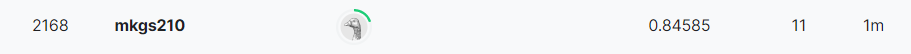

# CatBoost

In [ ]:
catboost = CatBoostClassifier(
    cat_features=cat_cols,
    logging_level="Silent",
    eval_metric="AUC:hints=skip_train~false",
    grow_policy="Lossguide",
    metric_period=1000,
    random_seed=0,
)

PARAMS = {
    "n_estimators": [250],  # [5, 10, 20, 30, 40, 50, 70, 100, 150, 200, 250, 300, 500, 1000],
    "learning_rate": [0.05],  # [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.02, 0.04, 0.05, 0.1, 0.2, 0.3, 0.5],
    "max_depth": [4],  # np.arange(4, 20, 1),
    "l2_leaf_reg": [10],  # np.arange(0.1, 1, 0.05),
    "subsample": [0.6],  # [3, 5, 7, 10],
    "random_strength": [5],  # [1, 2, 5, 10, 20, 50, 100],
    "min_data_in_leaf": [100],  # np.arange(10, 1001, 10),
}
catboost.grid_search(PARAMS, X_train, y_train, cv=5, plot=True, refit=True)

In [ ]:
print("Best score:", end=' ')
pprint(catboost.best_score_)
best_params = catboost.get_params()
for f in ("cat_features", "logging_level", "eval_metric"):
    best_params.pop(f)
print("Best params:", end=' ')
pprint(best_params)

In [ ]:
submission = pd.read_csv(INPUT_DIR + "submission.csv")
submission["Churn"] = catboost.predict_proba(X_test)[:, 1]
submission.to_csv(OUTPUT_DIR + "catboost.csv", index=False)

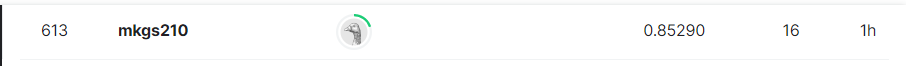

# KNN

In [ ]:
numeric_transformer = Pipeline(steps=[
    ("scaler", StandardScaler())
])
preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, num_cols),
        ("cat", OneHotEncoder(handle_unknown='ignore'), cat_cols)
    ]
)
PARAMS = {
    "model__n_neighbors": [44],  # range(1, 100),
    "model__metric": ["manhattan"],  # ["cityblock", "cosine", "euclidean", "l1", "l2", "manhattan", "nan_euclidean"],
}

clf = Pipeline(steps=[
    ("preproc", preprocessor),
    ("model", KNeighborsClassifier()),
])
    
grid_search = GridSearchCV(
    estimator=clf,
    param_grid=PARAMS,
    scoring="roc_auc",
    n_jobs=-1,
    cv=10,
    refit=True,
)
knn = grid_search.fit(X_train, y_train)

In [ ]:
print(f"best score: {knn.best_score_}")
print(f"best params: {knn.best_params_}")

In [ ]:
submission = pd.read_csv(INPUT_DIR + "submission.csv")
submission["Churn"] = knn.predict_proba(X_test)[:, 1]
submission.to_csv(OUTPUT_DIR + "knn.csv", index=False)

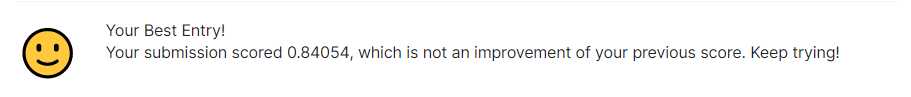

# Random Forest

In [ ]:
PARAMS = {
    "min_samples_split": [9],  # range(2, 200),
    "min_samples_leaf": [18],  # range(1, 200),
}
clf = RandomForestClassifier(n_estimators=200, random_state=42)

grid_search = GridSearchCV(clf, PARAMS, scoring="roc_auc", cv=5)
rf = grid_search.fit(X_train, y_train);

In [ ]:
print(f"Best score: {rf.best_score_}")
print(f"Best params: {rf.best_params_}")

In [ ]:
submission = pd.read_csv(INPUT_DIR + "submission.csv")
submission["Churn"] = rf.predict_proba(X_test)[:, 1]
submission.to_csv(OUTPUT_DIR + "rf.csv", index=False)

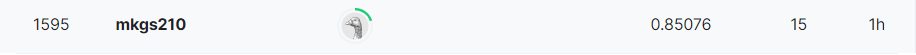

# Stacking

In [ ]:
meta = CatBoostClassifier(
    logging_level='Silent',
    eval_metric="AUC:hints=skip_train~false",
    metric_period=1000,
    random_seed=0,
    grow_policy="Depthwise",
    l2_leaf_reg=1,
    learning_rate=0.08,
    max_depth=10,
    min_data_in_leaf=10,
    n_estimators=10,
    random_strength=11,
    subsample=0.1,
)
stacking = StackingClassifier(
    estimators=[
        ("logreg", logreg),
        ("knn", knn),
        ("rf", rf),
        ("catboost", catboost),
    ],
    final_estimator=meta,
    n_jobs=-1,
)

stacking.fit(X_train, y_train)

# Final Prediction

In [ ]:
best_model = stacking

In [ ]:
y_pred = best_model.predict_proba(X_test)[:, 1]
submission = pd.read_csv(INPUT_DIR + "./submission.csv")
submission['Churn'] = y_pred
submission.to_csv(OUTPUT_DIR + "./my_submission.csv", index=False)

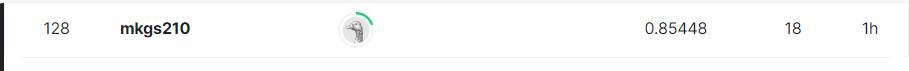